Fit1: y = 0.122x + 0.452
Fit2: y = 0.021x + 0.237


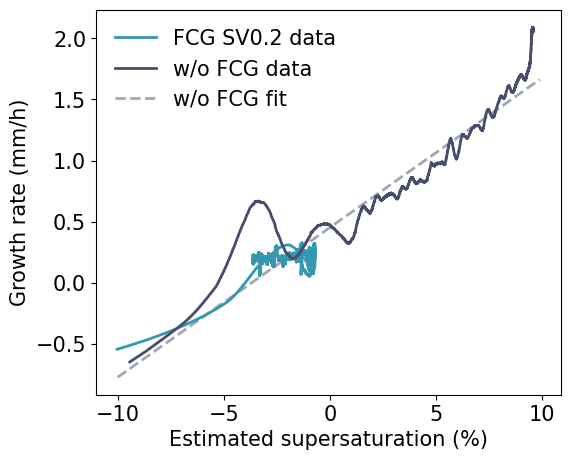

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# figure save option
save_option = True
figsavepath = "../Figures/FigureS14_supersaturation.svg"

# Read excel files
paths = ["../Data/00_FCG-excels/230724_B_HTSE.xlsx",
         "../Data/00_FCG-excels/230920_A_0.2mmh.xlsx"
        ]

df1 = pd.read_excel(paths[0]) # HTSE
df2 = pd.read_excel(paths[1]) # SV0.2

# Time
times1 = df1['Time (h)'].to_list()
times2 = df2['Time (h)'].to_list()
# Growth rate
grate1 = df1['Growth rate (mm/h)'].to_list()
grate2 = df2['Growth rate (mm/h)'].to_list()
# Estimated mass of the crystals from the image
est_mass1 = df1['Est-Mass (g)'].to_list()
est_mass2 = df2['Est-Mass (g)'].to_list()
# Total infusion
total_inf2 = df2['Total Inf'].to_list() # mL

# Correction for estimated mass based on the measured mass
mass_corr1 = 0.615 # g
mass_corr2 = 0.986 # g
est_mass1 = [n/mass_corr1 for n in est_mass1]
est_mass2 = [n/mass_corr2 for n in est_mass2]
seed_mass1 = est_mass1[0]
seed_mass2 = est_mass2[0]

# Delta mass (the amount of deposited crystals)
delta_mass1 = [n-seed_mass1 for n in est_mass1]
delta_mass2 = [n-seed_mass2 for n in est_mass2]

# Total infusion in (g)
total_inf_g2 = [n / total_inf2[-1] * 112.39 for n in total_inf2]

# Evaporation
evap1 = [2.35382892145071 * t for t in times1] # g/h * h
evap2 = [2.55978751206013 * t for t in times2] # g/h * h

# Estimated concentration (wt.%)
def estimate_concentration(m_solute0,m_solution0,m_deposition,m_evaporation,m_infusion):
    y = (m_solute0 - m_deposition) / (m_solution0 - m_evaporation + m_infusion - m_deposition) * 100
    return y
est_conc1 = [estimate_concentration(100.09*0.41,100.09,x1,x2,0) for x1, x2 in zip(delta_mass1,evap1)]
est_conc2 = [estimate_concentration(100.19*0.41,100.19,x1,x2,x3) for x1, x2, x3 in zip(delta_mass2,evap2,total_inf_g2)]

# Define Supersaturation Calculation
def temp_in_solution(time):
    # temperature profile *see FigS2
    T0 = 21.3767
    Tend = 40.6191
    k = 4.1604
    y = Tend + (T0 - Tend) * np.exp(-k * time) # time (hrs), temp (oC), based on Figure S2
    return y

def solubility(time):
    # solubility profile see FigS3
    T = temp_in_solution(time)
    S = 1.66151429e-03 * T * T - 5.54452231e-01 * T + 6.11548397e+01
    return S

def supersaturation(time, C):
    S = solubility(time)
    sigma = (C-S)/S*100 #%
    return sigma

sigma1 = [supersaturation(t,C) for t, C in zip(times1,est_conc1)]
sigma2 = [supersaturation(t,C) for t, C in zip(times2,est_conc2)]

# Cut the data for the first 10 mins (where growth rate cannot be defined)
def crop_data(sigma,grate):
    for i, g in enumerate(grate):
        if g != 0:
            break
    new_sigma = sigma[i:]
    new_grate = grate[i:]
    return new_sigma, new_grate

sigma1, grate1 = crop_data(sigma1,grate1)
sigma2, grate2 = crop_data(sigma2,grate2)

# fitting
X_fit1 = np.arange(-10,10,0.1)
a1, b1 = np.polyfit(sigma1,grate1,1)
Y_fit1 = [a1*n+b1 for n in X_fit1]

X_fit2 = X_fit1.copy()
a2, b2 = np.polyfit(sigma2,grate2,1)
Y_fit2 = [a2*n+b2 for n in X_fit2]

### Figure Plot ###
plt.rcParams["font.size"] = 15
fig = plt.figure(figsize=(6,5))

color1 = "#474D6B" # dark blue
color2 = '#3498B0' # light blue

plt.plot(sigma2,grate2,c=color2,linewidth=2,label='FCG SV0.2 data',zorder=2)
# plt.plot(X_fit2,Y_fit2,c=f"{color2}80",linestyle='dashed',linewidth=2,label='FCG SV0.2 fit',zorder=2)
plt.plot(sigma1,grate1,c=color1,linewidth=2,label='w/o FCG data',zorder=2)
plt.plot(X_fit1,Y_fit1,c=f"{color1}80",linestyle='dashed',linewidth=2,label='w/o FCG fit',zorder=1)
plt.xlabel('Estimated supersaturation (%)')
plt.ylabel('Growth rate (mm/h)')
plt.legend(frameon=False)
print(f'Fit1: y = {a1:.3f}x + {b1:.3f}')
print(f'Fit2: y = {a2:.3f}x + {b2:.3f}')

if save_option:
    plt.savefig(figsavepath, dpi=1200, bbox_inches='tight', transparent=True)